# Pytorch Workflow


In [710]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.7.0+cu128'

## 1. Data (Preparing and Loading)

In [711]:
#Linear Regression formula to make a line using known parameters

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data in train and test set

In [712]:
train_split = int(0.8*len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]


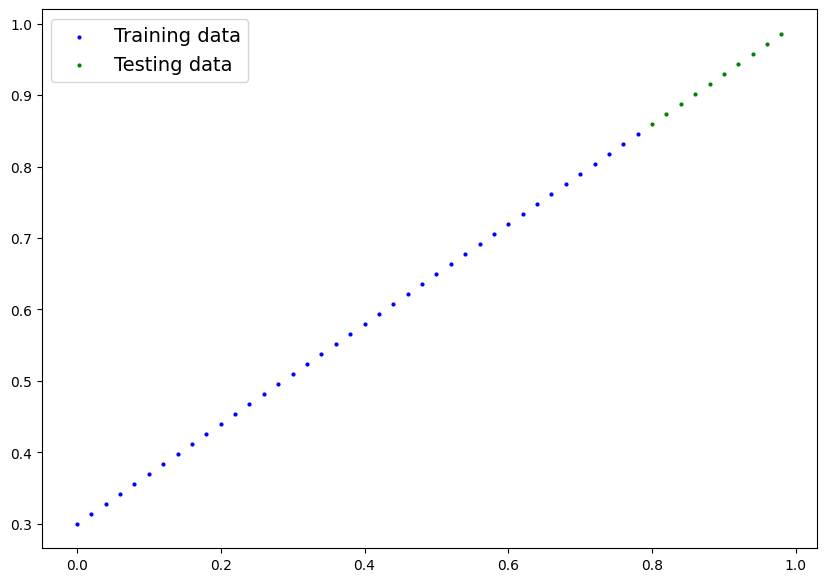

In [713]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    
    plt.figure(figsize=(10,7))

    plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")
    plt.scatter(test_data,test_labels,c="g",s=4,label="Testing data")

    if predictions is not None:
        plt.scatter(test_labels,predictions,c="r",s=4,label="Predictions")
    
    plt.legend(prop={"size":14})
    plt.show()

plot_predictions()

### Build Model

Now we will make a Linear Regression Model

In [714]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

        #Forward Method to define the computation in model
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.weights*x + self.bias

In [715]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

# Check the model's parameters
print(model_0.state_dict())
list(model_0.parameters())

OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [716]:
### Making predictions using torch.interence_mode()

with torch.inference_mode():
    y_preds = model_0(X_test) 

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [717]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

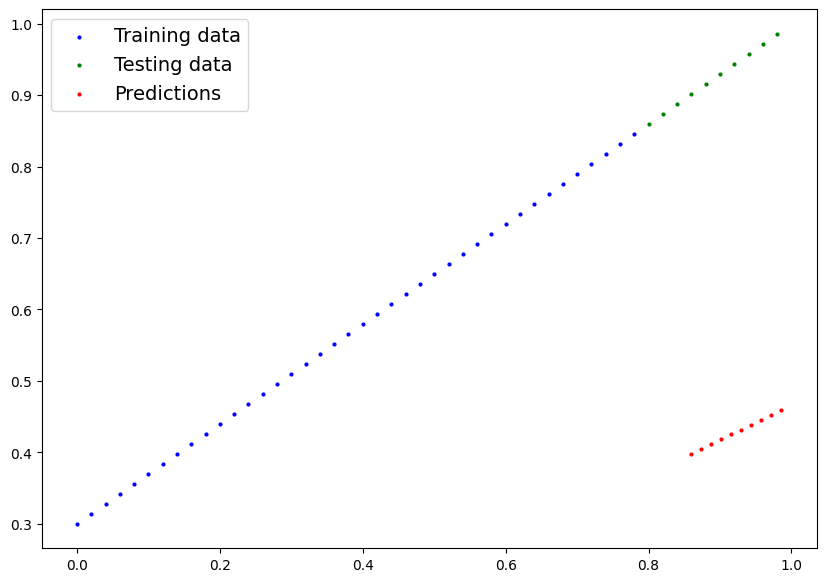

In [718]:
plot_predictions(predictions=y_preds)

In [719]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


In [720]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

### Train Model

In [721]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.002)

#### Building a training loop

A couple of things we need:
0. Loop through the data
1. Forward pass (this involves data moving through our model's forward functions) - forward propogation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backwards - move backwards throuh the network to calculate the gradient of each of the parameters of our model with respect to the loss
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss

In [722]:
# an epoch = one loop through the data
epochs = 10000
train_loss_values = []
test_loss_values = []
epoch_count = []

#0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode sets all paramters of model to trainable (requires_grad = True)

    # model_0.eval()  turns of gradient tracking for all parameters in the model

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred,y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # This is important to clear the gradients from the previous step
    # If we don't do this, the gradients will accumulate and cause issues

    # 4. Perform backpropagation on the loss wrt the model parameters
    loss.backward()
    # This calculates the gradients of the loss with respect to the model parameters
    # This is important to calculate the gradients for the optimizer to update the parameters
    # The gradients are stored in the model parameters' .grad attribute
    # For example, model_0.weights.grad will contain the gradient of the loss with respect to the weights

    # 5. Step the optimizer
    optimizer.step()
    # This updates the model parameters using the gradients calculated in the previous step
    # The optimizer uses the learning rate to update the parameters

    ## Testing

    model_0.eval() # eval mode sets all paramters of model to not trainable (requires_grad = False)
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred,y_test)
        train_loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        epoch_count.append(epoch)
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.31288 | Test Loss: 0.49184
Epoch: 1000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 2000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 3000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 4000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 5000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 6000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 7000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 8000 | Train Loss: 0.00184 | Test Loss: 0.00011
Epoch: 9000 | Train Loss: 0.00184 | Test Loss: 0.00011


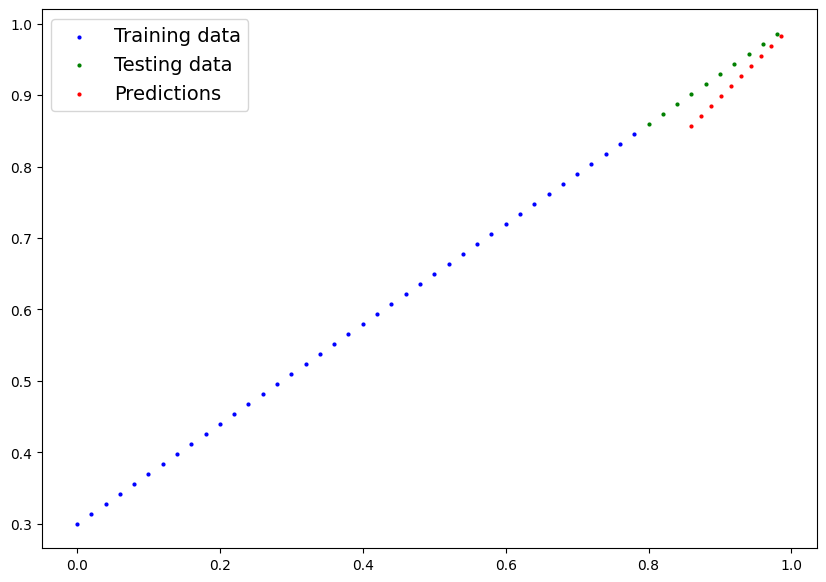

In [723]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)

In [724]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6981])), ('bias', tensor([0.2989]))])

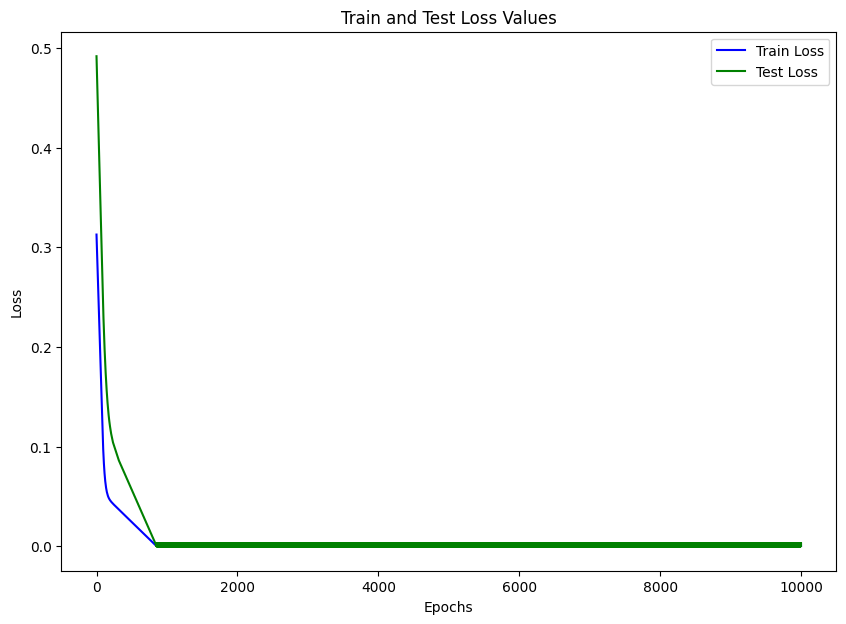

In [725]:
# Plot the test and train loss values
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, train_loss_values, label = "Train Loss", c = "b")
plt.plot(epoch_count, test_loss_values, label = "Test Loss", c = "g")
plt.title("Train and Test Loss Values")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [726]:
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6981]), 'bias': tensor([0.2989])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [727]:
model_0

LinearRegressionModel()

### Saving a Model on Pytorch

There are 3 methods:


1. `torch.save()` - allows you to store the model in python pickle format
2. `torch.load()` - allows you to load a saved pytorch obj
3. `torch.nn.Module.load_state_dict()` - this allows to load a models saved state dictionary


In [728]:
from pathlib import Path

# Create a model save directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = "linear_regression_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dictionary
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: models\linear_regression_model_0.pth


## Loading a PyTorch Model

since we saved the state_dict of the model , we will create instance of the model and load the saved state_dict into that

In [729]:
loaded_model_0 = LinearRegressionModel()
# Load the model state dictionary

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6981])), ('bias', tensor([0.2989]))])

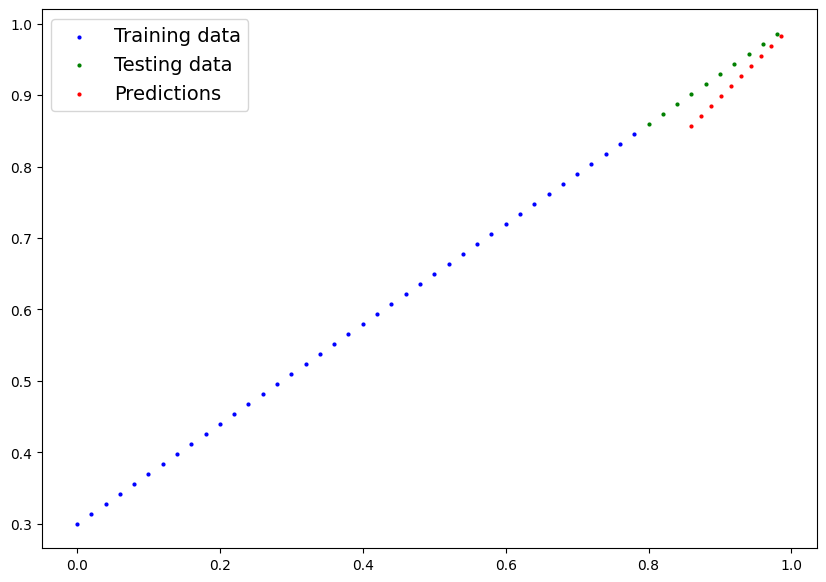

Are the loaded model predictions the same as the original model predictions? True


In [730]:
# Make predictions with the loaded model

loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

plot_predictions(predictions=loaded_model_preds)

# Check if the loaded model predictions are the same as the original model predictions
print(f"Are the loaded model predictions the same as the original model predictions? {torch.allclose(loaded_model_preds, y_preds_new)}")

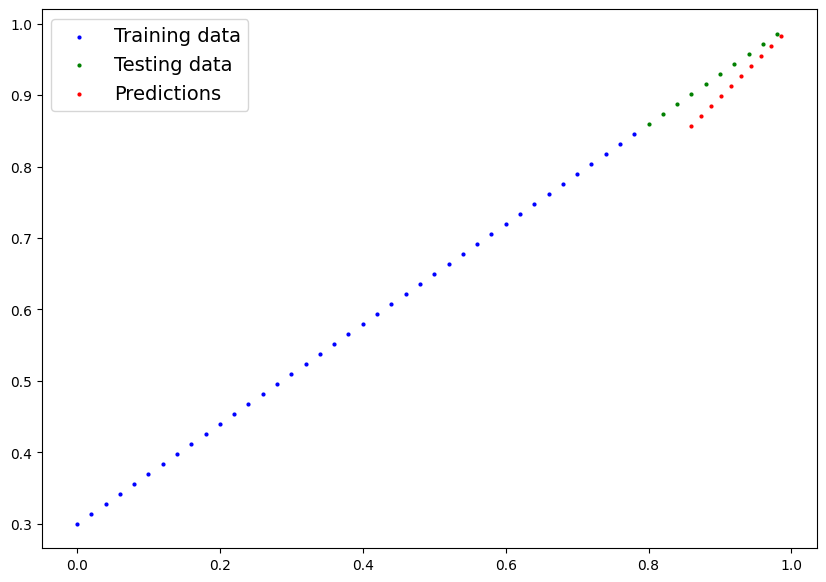

Are the predictions made on the device the same as the original model predictions? True


In [733]:
## Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# Move the model to the device
model_0.to(device)
# Move the data to the device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
# Make predictions with the model on the device
with torch.inference_mode():
    y_preds_device = model_0(X_test)
# Plot the predictions made on the device
plot_predictions(predictions=y_preds_device.cpu())
# Check if the predictions made on the device are the same as the original model predictions
print(f"Are the predictions made on the device the same as the original model predictions? {torch.allclose(y_preds_device.cpu(), y_preds_new)}")

In [736]:
!nvidia-smi
# Check if the model is on the device
print(f"Is the model on the device? {next(model_0.parameters()).is_cuda}")
# Check if the data is on the device
print(f"Is the training data on the device? {X_train.is_cuda}")

Wed Jun 25 00:48:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              3W /   60W |     247MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----